# DEMETER2 in Stan

In [100]:
import pystan
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az
from pathlib import Path
import seaborn as sns
from timeit import default_timer as timer

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

modeling_data_dir = Path('../modeling_data')

## Data preparation

In [101]:
modeling_data = pd.read_csv(modeling_data_dir / 'subset_modeling_data.csv')
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


## Exploratory data analysis

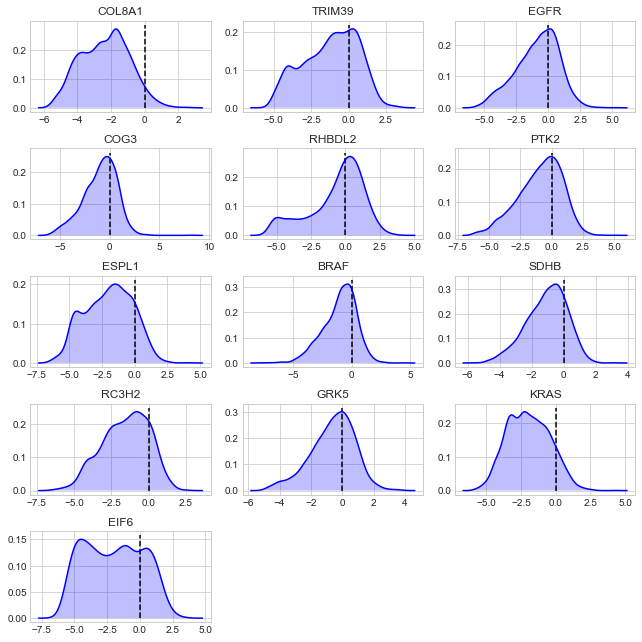

In [102]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(5, 3, figsize=(9, 9))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=False, ax=ax, kde_kws={'shade': True}, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

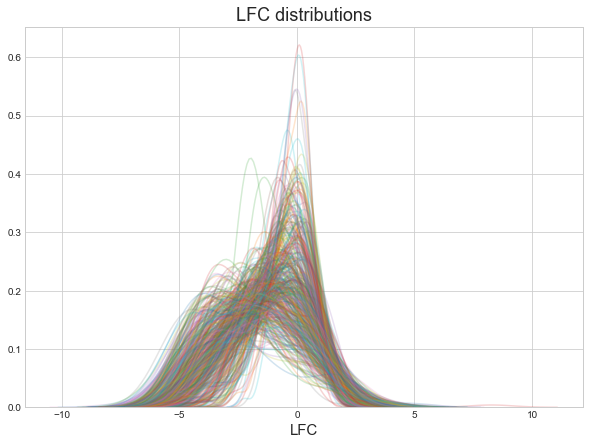

In [103]:
cell_lines = set(modeling_data.cell_line.to_list())
for cell_line in cell_lines:
    lfc = modeling_data[modeling_data.cell_line == cell_line].lfc
    sns.distplot(lfc, kde=True, hist=False, label=None, kde_kws={'alpha': 0.2})

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.show()

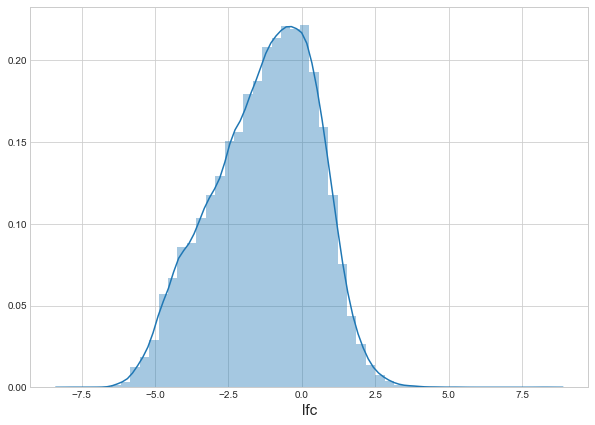

In [104]:
sns.distplot(modeling_data.lfc)
plt.show()

In [105]:
modeling_data[['barcode_sequence', 'gene_symbol']].drop_duplicates().groupby('gene_symbol').count()

,barcode_sequence
gene_symbol,
BRAF,8
COG3,5
COL8A1,5
EGFR,19
EIF6,5
ESPL1,5
GRK5,5
KRAS,11
PTK2,23


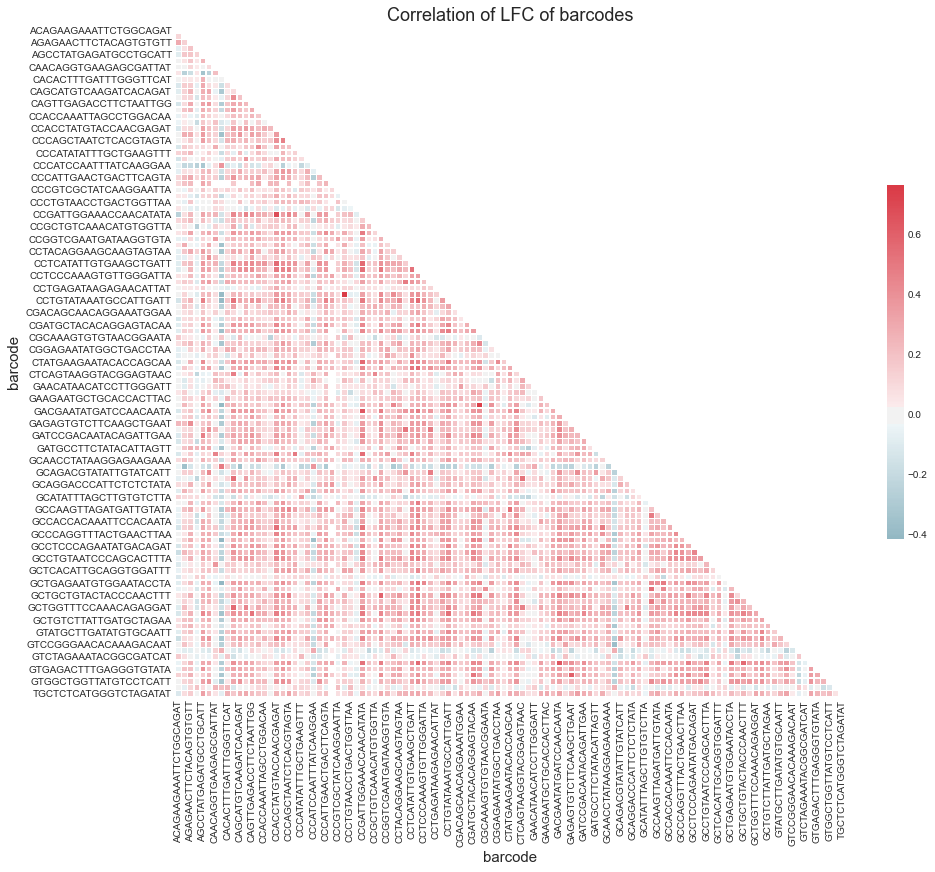

In [106]:
lfc_corr = modeling_data \
    .pivot(index='cell_line', columns='barcode_sequence', values='lfc') \
    .corr()

mask = np.triu(np.ones_like(lfc_corr, dtype=np.bool), k=0)
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lfc_corr, mask=mask, 
            cmap=cmap, center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.xlabel('barcode')
plt.ylabel('barcode')
plt.title('Correlation of LFC of barcodes')
plt.show()

## Modeling

In [107]:
models_dir = Path('..', 'models')

In [108]:
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


Select only a few cell lines while model building.

In [109]:
len(np.unique(modeling_data.cell_line))

501

In [110]:
np.random.seed(123)
cell_lines = np.random.choice(np.unique(modeling_data.cell_line), 100)
modeling_data = modeling_data[modeling_data.cell_line.isin(cell_lines)]
modeling_data.shape

(8243, 5)

In [111]:
def add_categorical_idx(df, col):
    df[f'{col}_idx'] = df[col].astype('category').cat.codes + 1
    return df

for col in ['barcode_sequence', 'cell_line', 'gene_symbol']:
    modeling_data = add_categorical_idx(modeling_data, col)

modeling_data = modeling_data.reset_index(drop=True)
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol,barcode_sequence_idx,cell_line_idx,gene_symbol_idx
0,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6,1,16,5
1,ACAGAAGAAATTCTGGCAGAT,igrov1_ovary,0.041360,1,EIF6,1,32,5
2,ACAGAAGAAATTCTGGCAGAT,colo783_skin,1.368993,1,EIF6,1,9,5
3,ACAGAAGAAATTCTGGCAGAT,tccsup_urinary_tract,-0.743686,1,EIF6,1,84,5
4,ACAGAAGAAATTCTGGCAGAT,thp1_haematopoietic_and_lymphoid_tissue,0.441765,1,EIF6,1,85,5


Binary matrix of $[shRNA \times gene]$.

In [112]:
shrna_gene_matrix = modeling_data[['barcode_sequence_idx', 'gene_symbol_idx']] \
    .drop_duplicates() \
    .reset_index(drop=True) \
    .assign(value = lambda df: np.ones(df.shape[0], dtype=int)) \
    .pivot(index='barcode_sequence_idx', columns='gene_symbol_idx', values='value') \
    .fillna(0) \
    .to_numpy() \
    .astype(int)

shrna_gene_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [113]:
shrna_gene_matrix.shape

(109, 13)

In [114]:
# d2_stan_data = {
#     'N': int(modeling_data.shape[0]),
#     'I': len(np.unique(modeling_data.barcode_sequence_idx)),
#     'J': len(np.unique(modeling_data.cell_line_idx)),
#     'K': len(np.unique(modeling_data.batch)),
#     'L': len(np.unique(modeling_data.gene_symbol_idx)),
    
#     'shrna': modeling_data.barcode_sequence_idx,
#     'cell_line': modeling_data.cell_line_idx,
#     'batch': modeling_data.batch,
#     'gene': modeling_data.gene_symbol_idx,
    
#     'y': modeling_data.lfc,
# }

**Model data.**

In [115]:
d2_stan_data = {
    'N': int(modeling_data.shape[0]),
    'I': len(np.unique(modeling_data.barcode_sequence_idx)),
    'J': len(np.unique(modeling_data.cell_line_idx)),
    'L': len(np.unique(modeling_data.gene_symbol_idx)),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'cell_line': modeling_data.cell_line_idx,
    'gene': modeling_data.gene_symbol_idx,
    
    'y': modeling_data.lfc
}

**Compile model.**

In [90]:
start = timer()
d2_stan_file = models_dir / 'd2_stan_model_2.cpp'
d2_stan_model = pystan.StanModel(file=d2_stan_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bce6bef0f8943d3c1f50a70a883a3f3a NOW.


1.00 minutes to compile model


**Sample from posterior.**

In [116]:
start = timer()
d2_stan_fit = d2_stan_model.sampling(data=d2_stan_data, iter=2000, chains=2)
end = timer()
print(f'{(end - start) / 60:.2f} minutes to sample from posterior.')

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


86.06 minutes to sample from posterior.


In [117]:
pystan.check_hmc_diagnostics(d2_stan_fit)

{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': False}

In [118]:
az_d2_stan = az.from_pystan(
    posterior=d2_stan_fit,
    posterior_predictive='yhat',
    observed_data=['y'],
    posterior_model=d2_stan_model
)
fit_summary = az.summary(az_d2_stan)
fit_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
q[0],-9416.637,4135.176,-17851.139,-3401.688,2688.631,2202.300,2.0,2.0,2.0,11.0,2.42
q[1],-6632.106,3051.197,-11994.276,-2547.648,1995.366,1637.844,2.0,2.0,3.0,12.0,2.28
q[2],-6168.424,2876.174,-12053.657,-2597.165,1864.711,1525.865,2.0,2.0,3.0,11.0,2.21
q[3],-6952.604,3260.876,-12730.041,-2159.801,1973.289,1579.385,3.0,3.0,3.0,11.0,2.02
q[4],-9292.417,3979.386,-16386.073,-3460.581,2465.763,1987.642,3.0,3.0,3.0,11.0,2.16
...,...,...,...,...,...,...,...,...,...,...,...
mu[8238],0.098,0.114,-0.100,0.324,0.003,0.003,1130.0,867.0,1145.0,1186.0,1.00
mu[8239],0.083,0.097,-0.086,0.264,0.003,0.002,1259.0,983.0,1280.0,1206.0,1.00
mu[8240],0.085,0.099,-0.093,0.269,0.003,0.002,1020.0,832.0,1073.0,1194.0,1.00
mu[8241],0.080,0.094,-0.097,0.253,0.003,0.002,1254.0,1035.0,1245.0,1134.0,1.00


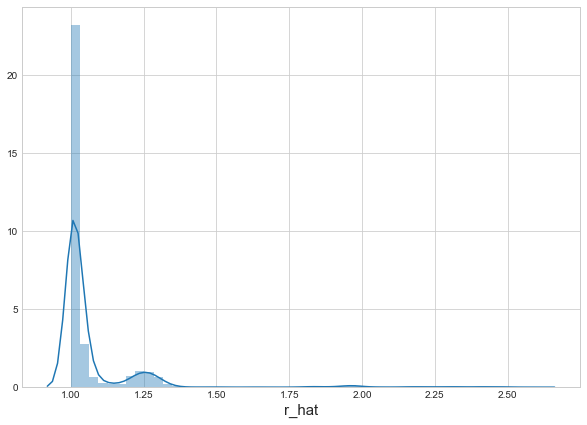

In [119]:
sns.distplot(fit_summary.r_hat)

/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/site-pack

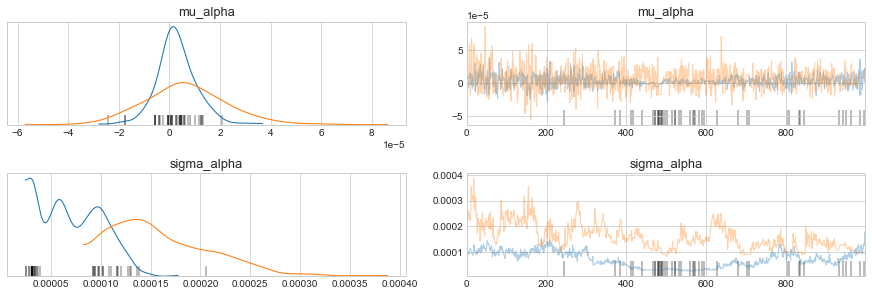

In [120]:
az.plot_trace(az_d2_stan, var_names=['mu_alpha', 'sigma_alpha'])
plt.show()

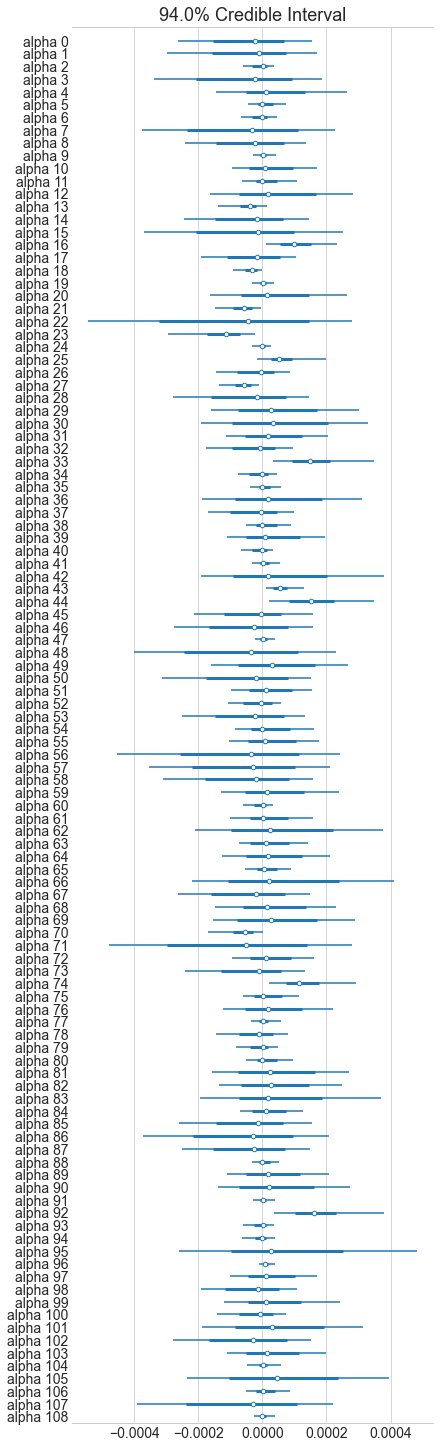

In [121]:
az.plot_forest(az_d2_stan, var_names='alpha', combined=True, figsize=(6, 20))
plt.show()

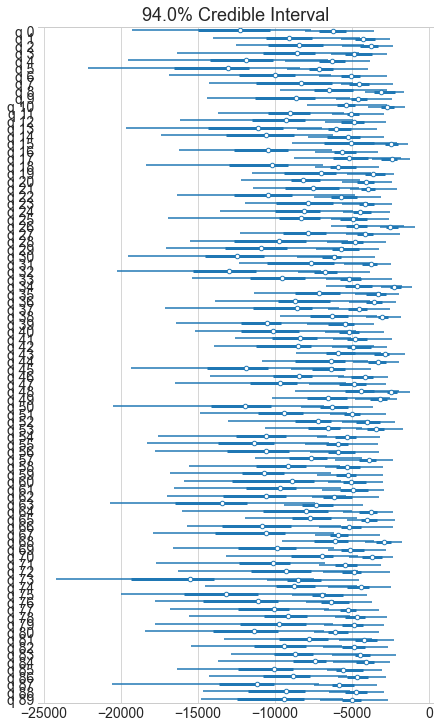

In [122]:
az.plot_forest(az_d2_stan, var_names='q', combined=False, figsize=(6, 10))
plt.show()

In [123]:
d2_stan_fit.to_dataframe()

,chain,draw,warmup,q[1],q[2],q[3],q[4],q[5],q[6],q[7],...,yhat[8241],yhat[8242],yhat[8243],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,-3059.375951,-2355.499214,-2449.040916,-2526.349751,-2782.628505,-3338.322976,-3084.890886,...,-0.828107,0.221874,-0.325438,1153.611750,9.403261e-01,0.001204,10,1023,0,-465.057978
1,0,1,0,-3069.061137,-2088.701714,-2388.372145,-2159.801221,-2897.396739,-3480.646116,-2945.116064,...,1.117705,0.188410,1.223637,1204.581053,8.900876e-01,0.001204,10,1023,0,-483.643496
2,0,2,0,-3144.215362,-2121.746655,-2350.028698,-2178.038528,-2741.308865,-3581.943795,-2807.688959,...,-1.654180,-1.022869,-0.025370,1188.952471,9.626327e-01,0.001204,10,1023,0,-498.150166
3,0,3,0,-3136.574632,-2184.065182,-2336.946457,-2295.407805,-2799.056528,-3584.225128,-2906.473552,...,-0.529787,0.702890,0.059859,1201.422244,8.871039e-01,0.001204,10,1023,0,-483.148393
4,0,4,0,-3149.935959,-1994.040581,-2452.227231,-2238.521970,-2809.275028,-3573.704163,-3049.314886,...,0.335599,0.185383,-0.330007,1219.404185,9.839279e-01,0.001204,10,1023,0,-531.292039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,995,0,-19152.378888,-13719.713718,-11376.946021,-16342.122456,-15588.554333,-21623.084970,-16567.328979,...,-0.054959,0.365720,0.265134,3107.553317,1.108038e-04,0.003413,8,255,0,-2391.859633
1996,1,996,0,-19152.378888,-13719.713718,-11376.946021,-16342.122456,-15588.554333,-21623.084970,-16567.328979,...,0.399200,-0.589628,0.275871,3107.553317,9.867745e-07,0.003413,8,255,0,-2410.312359
1997,1,997,0,-19152.411307,-13717.486240,-11382.988360,-16342.189949,-15582.589176,-21639.709928,-16574.559053,...,-0.034296,-0.117942,-0.146637,3099.358616,5.762867e-03,0.003413,6,106,1,-2450.106520
1998,1,998,0,-19152.411307,-13717.486240,-11382.988360,-16342.189949,-15582.589176,-21639.709928,-16574.559053,...,-0.662530,0.003479,0.907341,3099.358616,8.069089e-08,0.003413,8,255,0,-2419.353789


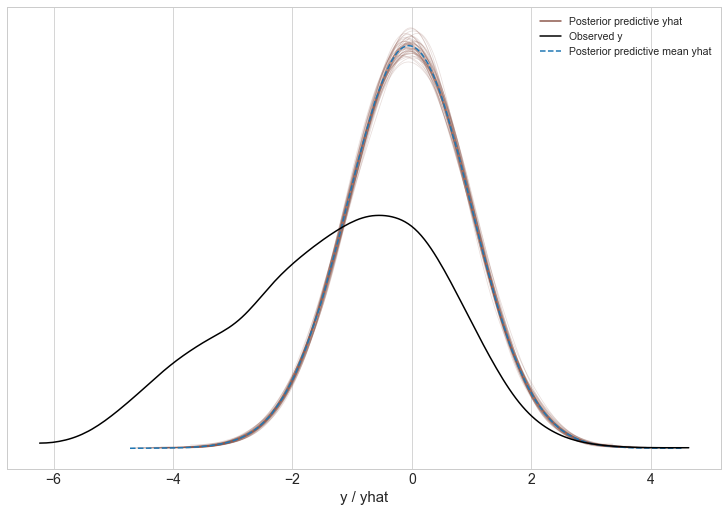

In [124]:
az.plot_ppc(az_d2_stan, data_pairs={'y':'yhat'}, num_pp_samples=50)
plt.show()